In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import __version__ as ma_ver
import matplotlib.pyplot as plt


from sklearn import __version__ as sk_ver
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, silhouette_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import make_scorer, fbeta_score
from catboost import CatBoostClassifier, Pool, __version__ as catb_v
from sklearn.feature_extraction.text import TfidfVectorizer

from plotly import __version__ as pl_ver
from plotly.tools import FigureFactory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.colors import n_colors
import plotly.express as px
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

from joblib import dump, load, __version__ as joblib_ver

# import util

In [3]:
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", ma_ver)
print("sklearn version:", sk_ver)
print("plotly version:", pl_ver)
print("catboost version:", catb_v)
print("joblib version:", joblib_ver)

pandas version: 1.3.4
seaborn version: 0.12.2
numpy version: 1.24.3
matplotlib version: 3.7.2
sklearn version: 1.3.0
plotly version: 5.19.0
catboost version: 1.2.3
joblib version: 1.2.0


# Загрузка файлов

In [4]:
data = pd.read_csv("dataset_bmm.csv")
data['processed_prompt'] = pd.read_csv('processed_prompt_data.csv')
data['target'] = data['target'].astype(int).astype('category') # для катбуста
data['model_response'] = data['model_response'].astype(str)
data

,prompt,canonical_solution,model_response,target,processed_prompt
0,<file_sep><fim_prefix>// Copyright 2020 The Go...,\t\tswitch x.Interface().(type) {,\t\t// False sorts before true.,0,copyright 2020 go author right reserved use so...
1,<file_sep><fim_prefix>import re\nimport uuid\n...,"st.markdown(""---"")","if st.session_state[""mdl_json""]:",0,import import uuid import orjson import stream...
2,<file_sep><fim_prefix>package tlsrpt\nimport (...,func (p *parser) wsp() {,//../rfc/8460:374,0,package tlsrpt import fmt string extension add...
3,"<file_sep><fim_prefix>import { describe, expec...",expect(() => (rect = new class_test.Rect()...,expect(() => (rect = new class_test.Rectan...,0,import describe expect test const require cons...
4,<file_sep><fim_prefix>import type {\n Default...,* Include or exclude stale queries,* Include queries matching this mutation key,0,import type defaulterror enabled fetchstatus m...
...,...,...,...,...,...
6657,"<file_sep><fim_prefix>import { describe, expec...","queryKey: ['key'],","queryKey: ['key'],",1,import describe expecttypeof import injectquer...
6658,<file_sep><fim_prefix>import moment from'momen...,dateRangeType: DateRangeType;,dateRangeType: DateRangeType;,1,import moment import type moment import datemo...
6659,<file_sep><fim_prefix>package dkim\nimport (\n...,"func (p *parser) xalgorithm() (string, string) {",//../rfc/6376:658,0,package dkim import fmt strconv string pedanti...
6660,<file_sep><fim_prefix>package com.tencent.supe...,String line;,String line = br.readLine();,0,package import static import import import imp...


In [7]:
%%time
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_prompt'])

tfidf_matrix = normalize(tfidf_matrix, norm='l2', axis=1)

KeyboardInterrupt: 

In [5]:
%%time
svd = TruncatedSVD(n_components=3, random_state=42)
PCs_3d = pd.DataFrame(svd.fit_transform(
    tfidf_matrix))
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

new_features = pd.read_csv('new_features.csv')

join_df = pd.concat([PCs_3d, new_features.drop(columns=['target', 'model_response_length', 'model_response_unique'])], axis=1, join='inner')
join_df_cols = join_df.columns
std_scaler = StandardScaler()
join_df = pd.DataFrame(std_scaler.fit_transform(join_df), columns=join_df_cols)
join_df

CPU times: total: 531 ms
Wall time: 248 ms


,PC1_3d,PC2_3d,PC3_3d,prompt_length,prompt_unique,prompt_{,prompt_},prompt_;,prompt_<,prompt_>,prompt_#,prompt_:,prompt_&,prompt_nil,prompt_#include,prompt_import,prompt_java
0,-0.660227,-0.429241,-0.058012,-0.552438,-0.322668,-0.583318,-0.569906,-0.562931,-0.206516,-0.519429,-0.325307,-0.729119,1.448684,-0.010529,-0.279701,-0.597592,-0.309105
1,-0.594210,0.444247,-0.538410,-0.217155,-0.308665,-0.773261,-0.729447,-0.562931,-0.479397,-0.519429,-0.325307,-0.320404,-0.506400,-0.342431,-0.279701,-0.209537,-0.309105
2,1.113586,-0.977653,-0.020422,-0.168538,0.699551,0.619651,0.674510,-0.350309,0.011789,-0.186250,-0.325307,-0.171781,2.705524,-0.010529,-0.279701,-0.597592,-0.309105
3,-0.848903,0.255661,1.615738,-0.582666,-0.798770,-0.583318,-0.601814,0.712800,-0.479397,0.396813,-0.325307,-0.673385,-0.506400,-0.342431,-0.279701,-0.597592,-0.309105
4,-0.312973,0.479682,0.992593,-1.063297,-0.994812,-0.773261,-0.761355,-0.562931,-0.479397,-0.477782,-0.325307,-0.673385,-0.506400,-0.342431,-0.279701,-0.403564,-0.309105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6657,-0.197924,0.574632,1.310852,-0.949185,-1.015817,-0.425033,-0.474182,-0.562931,-0.151940,0.105281,-0.325307,-0.654807,-0.506400,-0.342431,-0.279701,-0.306550,-0.309105
6658,-0.798751,0.027933,0.561856,2.335883,1.049626,2.645705,2.684721,2.272027,-0.479397,0.355165,-0.325307,2.689225,-0.227102,-0.342431,-0.279701,-0.209537,-0.309105
6659,1.211024,-0.924240,0.000028,-0.545888,-0.098620,0.081481,0.132072,-0.562931,-0.424821,-0.352840,-0.325307,-0.469028,-0.227102,-0.342431,-0.279701,-0.597592,-0.309105
6660,1.359338,1.885335,-1.946448,-0.591987,-0.665742,-0.646632,-0.761355,0.452929,-0.206516,-0.311193,-0.325307,-0.766275,-0.506400,-0.342431,-0.279701,2.312825,6.797554


# Catboost

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(join_df, data['target'].astype(int), test_size=.2, random_state=42)
train_dataset = Pool(X_train, y_train)
val_dataset = Pool(X_valid, y_valid)

cat_default = CatBoostClassifier(eval_metric='F:beta=1.25')
cat_default.fit(train_dataset, use_best_model=True, eval_set=val_dataset)

print(f'F_1.25 score - {fbeta_score(y_valid, cat_default.predict(val_dataset), beta=1.25)}')

Learning rate set to 0.047906
0:	learn: 0.0471638	test: 0.0270706	best: 0.0270706 (0)	total: 165ms	remaining: 2m 45s
1:	learn: 0.1404110	test: 0.1190624	best: 0.1190624 (1)	total: 169ms	remaining: 1m 24s
2:	learn: 0.1306480	test: 0.1140235	best: 0.1190624 (1)	total: 173ms	remaining: 57.4s
3:	learn: 0.1525534	test: 0.1295419	best: 0.1295419 (3)	total: 176ms	remaining: 43.8s
4:	learn: 0.1108550	test: 0.0868705	best: 0.1295419 (3)	total: 179ms	remaining: 35.6s
5:	learn: 0.1088443	test: 0.0729693	best: 0.1295419 (3)	total: 182ms	remaining: 30.1s
6:	learn: 0.0927499	test: 0.0502487	best: 0.1295419 (3)	total: 185ms	remaining: 26.2s
7:	learn: 0.1063573	test: 0.0646549	best: 0.1295419 (3)	total: 191ms	remaining: 23.6s
8:	learn: 0.1084775	test: 0.0647291	best: 0.1295419 (3)	total: 195ms	remaining: 21.4s
9:	learn: 0.1013811	test: 0.0732195	best: 0.1295419 (3)	total: 198ms	remaining: 19.6s
10:	learn: 0.1012327	test: 0.0703712	best: 0.1295419 (3)	total: 200ms	remaining: 18s
11:	learn: 0.1103995	te

## С параметрами

In [7]:
param_grid = {
    'depth': [2, 3, 4, 5],
    'learning_rate': [0.02, 0.03, 0.04, 0.1],
    'iterations' : [100, 300, 500, 800, 1000],
    'bagging_temperature' : [1, 1.2, 1.5]
    }
base_params = {
    'logging_level':'Silent',
    'loss_function':'Logloss',
    'l2_leaf_reg': 3,
    'random_strength': 1.2,
    'eval_metric': 'F:beta=1.25', 
    'random_state': 42,
}
cat_param = CatBoostClassifier(**base_params)
search = cat_param.grid_search(param_grid, train_dataset, cv=5)
cat_param.fit(train_dataset, use_best_model=True, eval_set=val_dataset)

0:	loss: 0.0409672	best: 0.0409672 (0)	total: 197ms	remaining: 47.1s
1:	loss: 0.0686564	best: 0.0686564 (1)	total: 351ms	remaining: 41.8s
2:	loss: 0.1200869	best: 0.1200869 (2)	total: 503ms	remaining: 39.7s
3:	loss: 0.2021626	best: 0.2021626 (3)	total: 655ms	remaining: 38.6s
4:	loss: 0.1621597	best: 0.2021626 (3)	total: 1.11s	remaining: 52.1s
5:	loss: 0.1975298	best: 0.2021626 (3)	total: 1.57s	remaining: 1m 1s
6:	loss: 0.2491560	best: 0.2491560 (6)	total: 2.04s	remaining: 1m 7s
7:	loss: 0.3205169	best: 0.3205169 (7)	total: 2.5s	remaining: 1m 12s
8:	loss: 0.2350274	best: 0.3205169 (7)	total: 3.24s	remaining: 1m 23s
9:	loss: 0.2754645	best: 0.3205169 (7)	total: 3.98s	remaining: 1m 31s
10:	loss: 0.2837948	best: 0.3205169 (7)	total: 4.78s	remaining: 1m 39s
11:	loss: 0.3631392	best: 0.3631392 (11)	total: 5.55s	remaining: 1m 45s
12:	loss: 0.2897765	best: 0.3631392 (11)	total: 6.74s	remaining: 1m 57s
13:	loss: 0.3000976	best: 0.3631392 (11)	total: 8.01s	remaining: 2m 9s
14:	loss: 0.3258106	be

In [8]:
print(search['params'])
print(f'F_1.25 score - {fbeta_score(y_valid, cat_param.predict(val_dataset), beta=1.25)}')

{'bagging_temperature': 1, 'depth': 4, 'learning_rate': 0.1, 'iterations': 1000}
F_1.25 score - 0.42050153036567683


In [ ]:
def get_scores(y_true, y_pred) -> pd.Series:
    return pd.Series(np.array([accuracy_score(y_true, y_pred), 
                     recall_score(y_true, y_pred), 
                     f1_score(y_true, y_pred),
                     precision_score(y_true, y_pred),
                     fbeta_score(y_true, y_pred, beta=1.25),
                     roc_auc_score(y_true, y_pred)]), 
                     index=['Accuracy', 'Recall', 'F1', 'Precision', 'F_beta', 'ROC_AUC'])

In [9]:
catboost_results = pd.DataFrame({
    'catboost_default': util.get_scores(y_valid, cat_default.predict(val_dataset)),
    'catboost_grid': util.get_scores(y_valid, cat_param.predict(val_dataset))
}).T
catboost_results

,Accuracy,Recall,F1,Precision,F_beta,ROC_AUC
catboost_default,0.643661,0.362617,0.449594,0.591463,0.427106,0.597349
catboost_grid,0.639160,0.357009,0.442642,0.582317,0.420502,0.592665


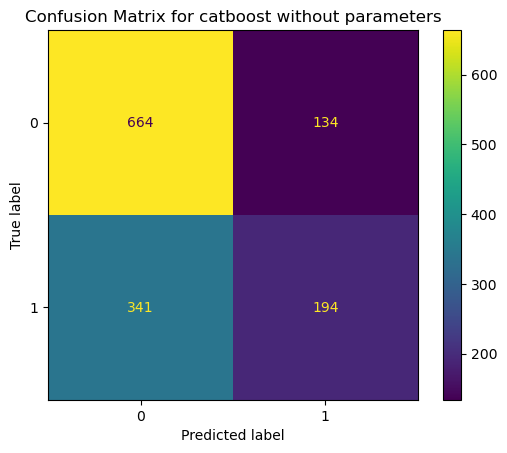

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, cat_default.predict(val_dataset)),display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for catboost without parameters")
plt.show()

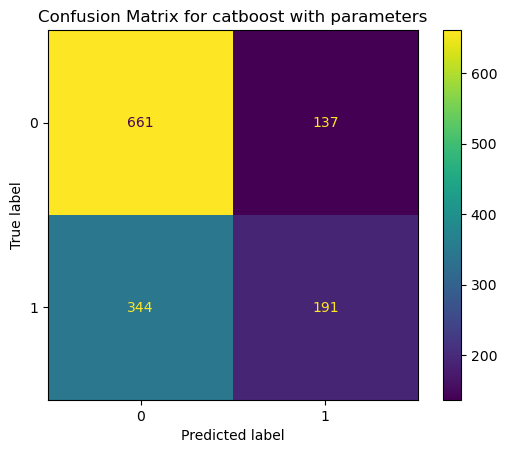

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, cat_param.predict(val_dataset)),display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for catboost with parameters")
plt.show()

# Cross-Validation 2.0

In [16]:
def optimize_catboost(df_features, tfidf_matrix, target, beta=1.25):
    # Преобразуем tfidf_matrix в DataFrame
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix)
    tfidf_df.columns = tfidf_df.columns.astype(str)
    
    # Объединяем df_features и tfidf_df
    combined_features = pd.concat([df_features.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(combined_features, 
                                                        target, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=target)
    # Стратифицированное разделение данных на обучающую и тестовую выборки гарантирует, 
    # что в каждой из выборок будет представлено одинаковое соотношение классов.
    
    
    # Определяем параметры для GridSearchCV
    param_grid = {
        'preprocessor__tfidf__n_components': [3, 50, 100],
        'catboost__iterations': [100, 200, 400, 800],
        'catboost__learning_rate': [0.03, 0.1],
        'catboost__depth': [3, 4, 6, 8],
        'catboost__bagging_temperature' : [1, 1.2, 1.5]
    }
    base_params = {
        'logging_level':'Info',
        'loss_function':'Logloss',
        'l2_leaf_reg': 3,
        'random_strength': 1.2,
        'eval_metric': f'F:beta={beta}',
        'random_state': 42,
    }
    
    # Создаем пайплайн
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(
        transformers=[
            ('tfidf', TruncatedSVD(random_state=42), tfidf_df.columns), #svm 
            ('num', StandardScaler(), df_features.columns)
        ]
        )),
        ('catboost', CatBoostClassifier(**base_params))  # CatBoostClassifier
    ])

    # Определяем метрику f_beta
    scorer = make_scorer(fbeta_score, beta=beta)

    # Создаем кросс-валидатор
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Создаем GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scorer, n_jobs=-1, verbose=10)

    # Обучаем GridSearchCV
    grid_search.fit(X_train, y_train)

    # Проверяем лучшую модель на тестовой выборке
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_score = fbeta_score(y_test, y_pred, beta=beta)
    
    print("F_beta score on test set: ", test_score)

    return best_model, util.get_scores(y_test, y_pred)
model, scores = optimize_catboost(new_features.drop(columns=['target', 'model_response_length', 'model_response_unique']), tfidf_matrix, data['target'])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


KeyboardInterrupt: 

In [ ]:
scores